The two PANDA networks corresponding to luminal A patients and their normal-adjacent tissue from the Cancer Genome Atlas project (TCGA BRCA) for this experiment are uploaded in Zenodo with DOI 10.5281/zenodo.10558426. The corresponding configuration file is in folder configs with name config_panda_BRCA_LUMA_nt.json. Depending on the desired structure of your directory, you may gave to adjust the save_dir and data_dir arguments. As the config data_preprocessing arguments suggest, the "project_unipartite_on": "columns" option will symmetrize the two bipartite PANDA networks by projecting them to gene space that represents co-regulation. This is done because this notebook only considers symmetric unipartite networks. 


In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")


import pandas as pd
import numpy as np

In [2]:
## experiment info that will be used for folder names and printing/saving the over-representation (ORA) results

tissue = 'BRCA'
target = 'nVSluma'
network_inf_method = 'PANDA'
ora_exp_parent_folder_name = 'PANDA_BRCA_lumaVSadjnorm_paper'
save_gsea_results_notes = ''

In [3]:
# read the configuration file 
from node2vec2rank.dataloader import DataLoader
import json

config = json.load(open('../configs/config_panda_BRCA_LUMA_nt.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}



In [4]:
# load the data
dataloader = DataLoader(config)

Loading graphs in memory ...
	There are 997 row nodes and 25410 column nodes in graph 1
	There are 997 row nodes and 25410 column nodes in graph 2
	Graphs are non-square and will be projected on column nodes
	There are 25410 common nodes and resulting networks will have size 25410 by 25410
Transforming graphs ...
	 to_unipartite
Finished loading in 70.94 seconds 



In [5]:
#run n2v2r to get the borda and dedi rankings
from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, nodes=dataloader.interest_nodes)
rankings = model.fit_transform_rank()
DeDi_rankings = model.degree_difference_ranking()
borda_ranking = model.aggregate_transform()

../output/01_23_2024_20_43_22

Running n2v2r with dimensions [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] and distance metrics ['euclidean', 'cosine'] ...
	Multi-layer embedding in 275.58 seconds
n2v2r computed 22 rankings for 1 comparison(s) in 284.24 seconds

Rank aggregation with Borda ...
	Finished aggregation in 6.41 seconds


In [6]:
##get the rankings of the comparison and map the ensemble IDs to symbols. TCGA uses gencode v26

#given that this is a sequential analysis with a pair of graphs, we are interested in the 1st comparison 
comparison = '1'
n2v2r_borda_ranking_pd = borda_ranking[comparison].copy()
absDeDi_ranking_pd = DeDi_rankings[comparison][['absDeDi']].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_borda_ranking_pd.index = genes_mapped
absDeDi_ranking_pd.index = genes_mapped

In [7]:
# run overrepresentation analysis 
from node2vec2rank.post_utils import enrichr_gseapy
import os

save_results = True

# the gene set library
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'

# take the top 2 percentage of the ranking for enrichment
top_k_percent = 2
gobp_background = n2v2r_borda_ranking_pd.index.to_list()
organism = 'human'

absDeDi_ORA_GOBP_pd = enrichr_gseapy(absDeDi_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
n2v2r_borda_ORA_GOBP_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)


if save_results:
    path = '../results/results_gsea/' + ora_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_borda_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                            "_n2v2r_borda_ORA_GOBP_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                            "_absDeDi"+"_ORA_GOBP_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        

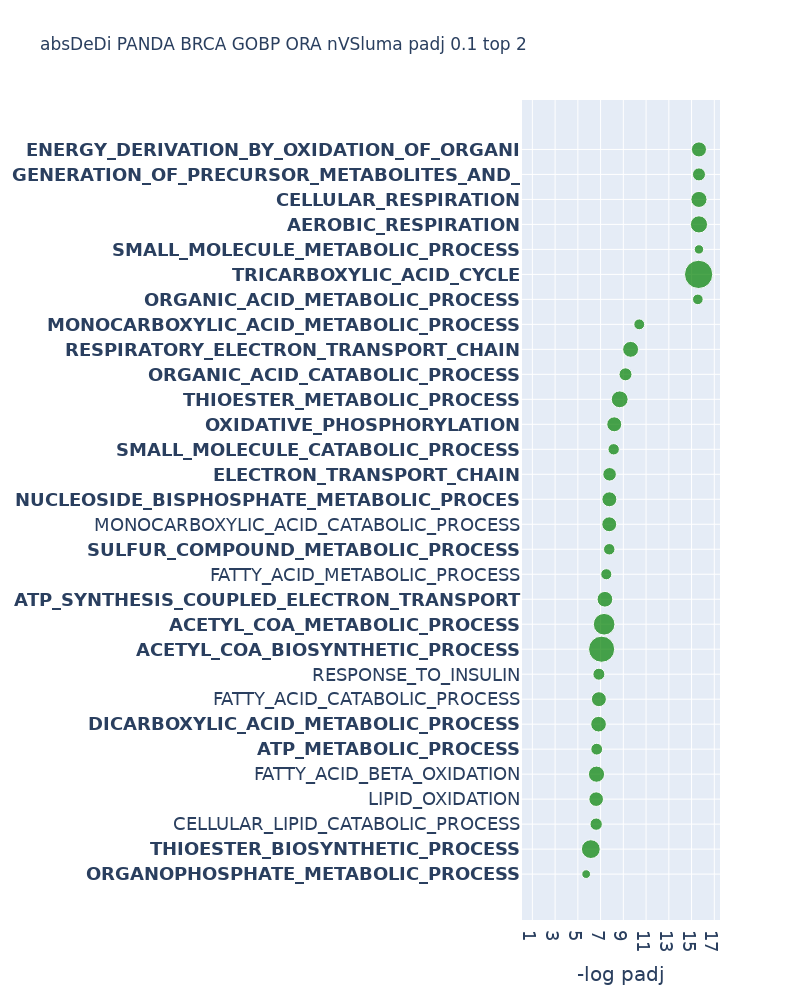

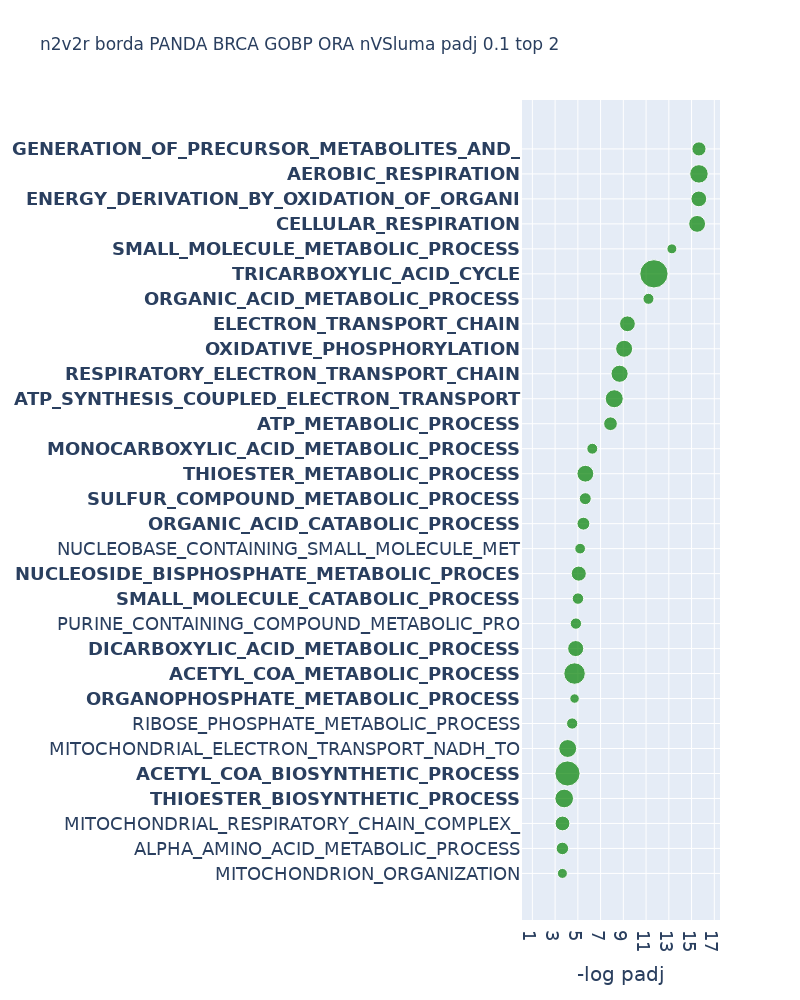

In [8]:
#plot the overrepresentation results

from node2vec2rank.post_utils import plot_gseapy_enrich 

padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + ora_exp_parent_folder_name

#Setting this to True, will allow the notebook figures to be interactive, e.g., hover over points and get more info
#Setting this to False will show the figure as png and non-interactive
#If True, the figures won't be shown when published on github, which is why we set it False here
interactive = False

title = network_inf_method+ " " +  tissue +  " GOBP ORA " + target + " padj " + str(padj_cutoff) + " top " + str(top_k_percent)

to_bold_from_dedi=plot_gseapy_enrich(absDeDi_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, plot=False)['pathway'].values
to_bold_from_n2v2r_borda=plot_gseapy_enrich(n2v2r_borda_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, plot=False)['pathway'].values

plot_gseapy_enrich(absDeDi_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, title="absDeDi " + title,output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda,interactive=interactive);

plot_gseapy_enrich(n2v2r_borda_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40, trim_first_num_characters=5,has_stability=False,  title="n2v2r borda " + title,output_dir=save_directory,to_bold=to_bold_from_dedi,interactive=interactive);


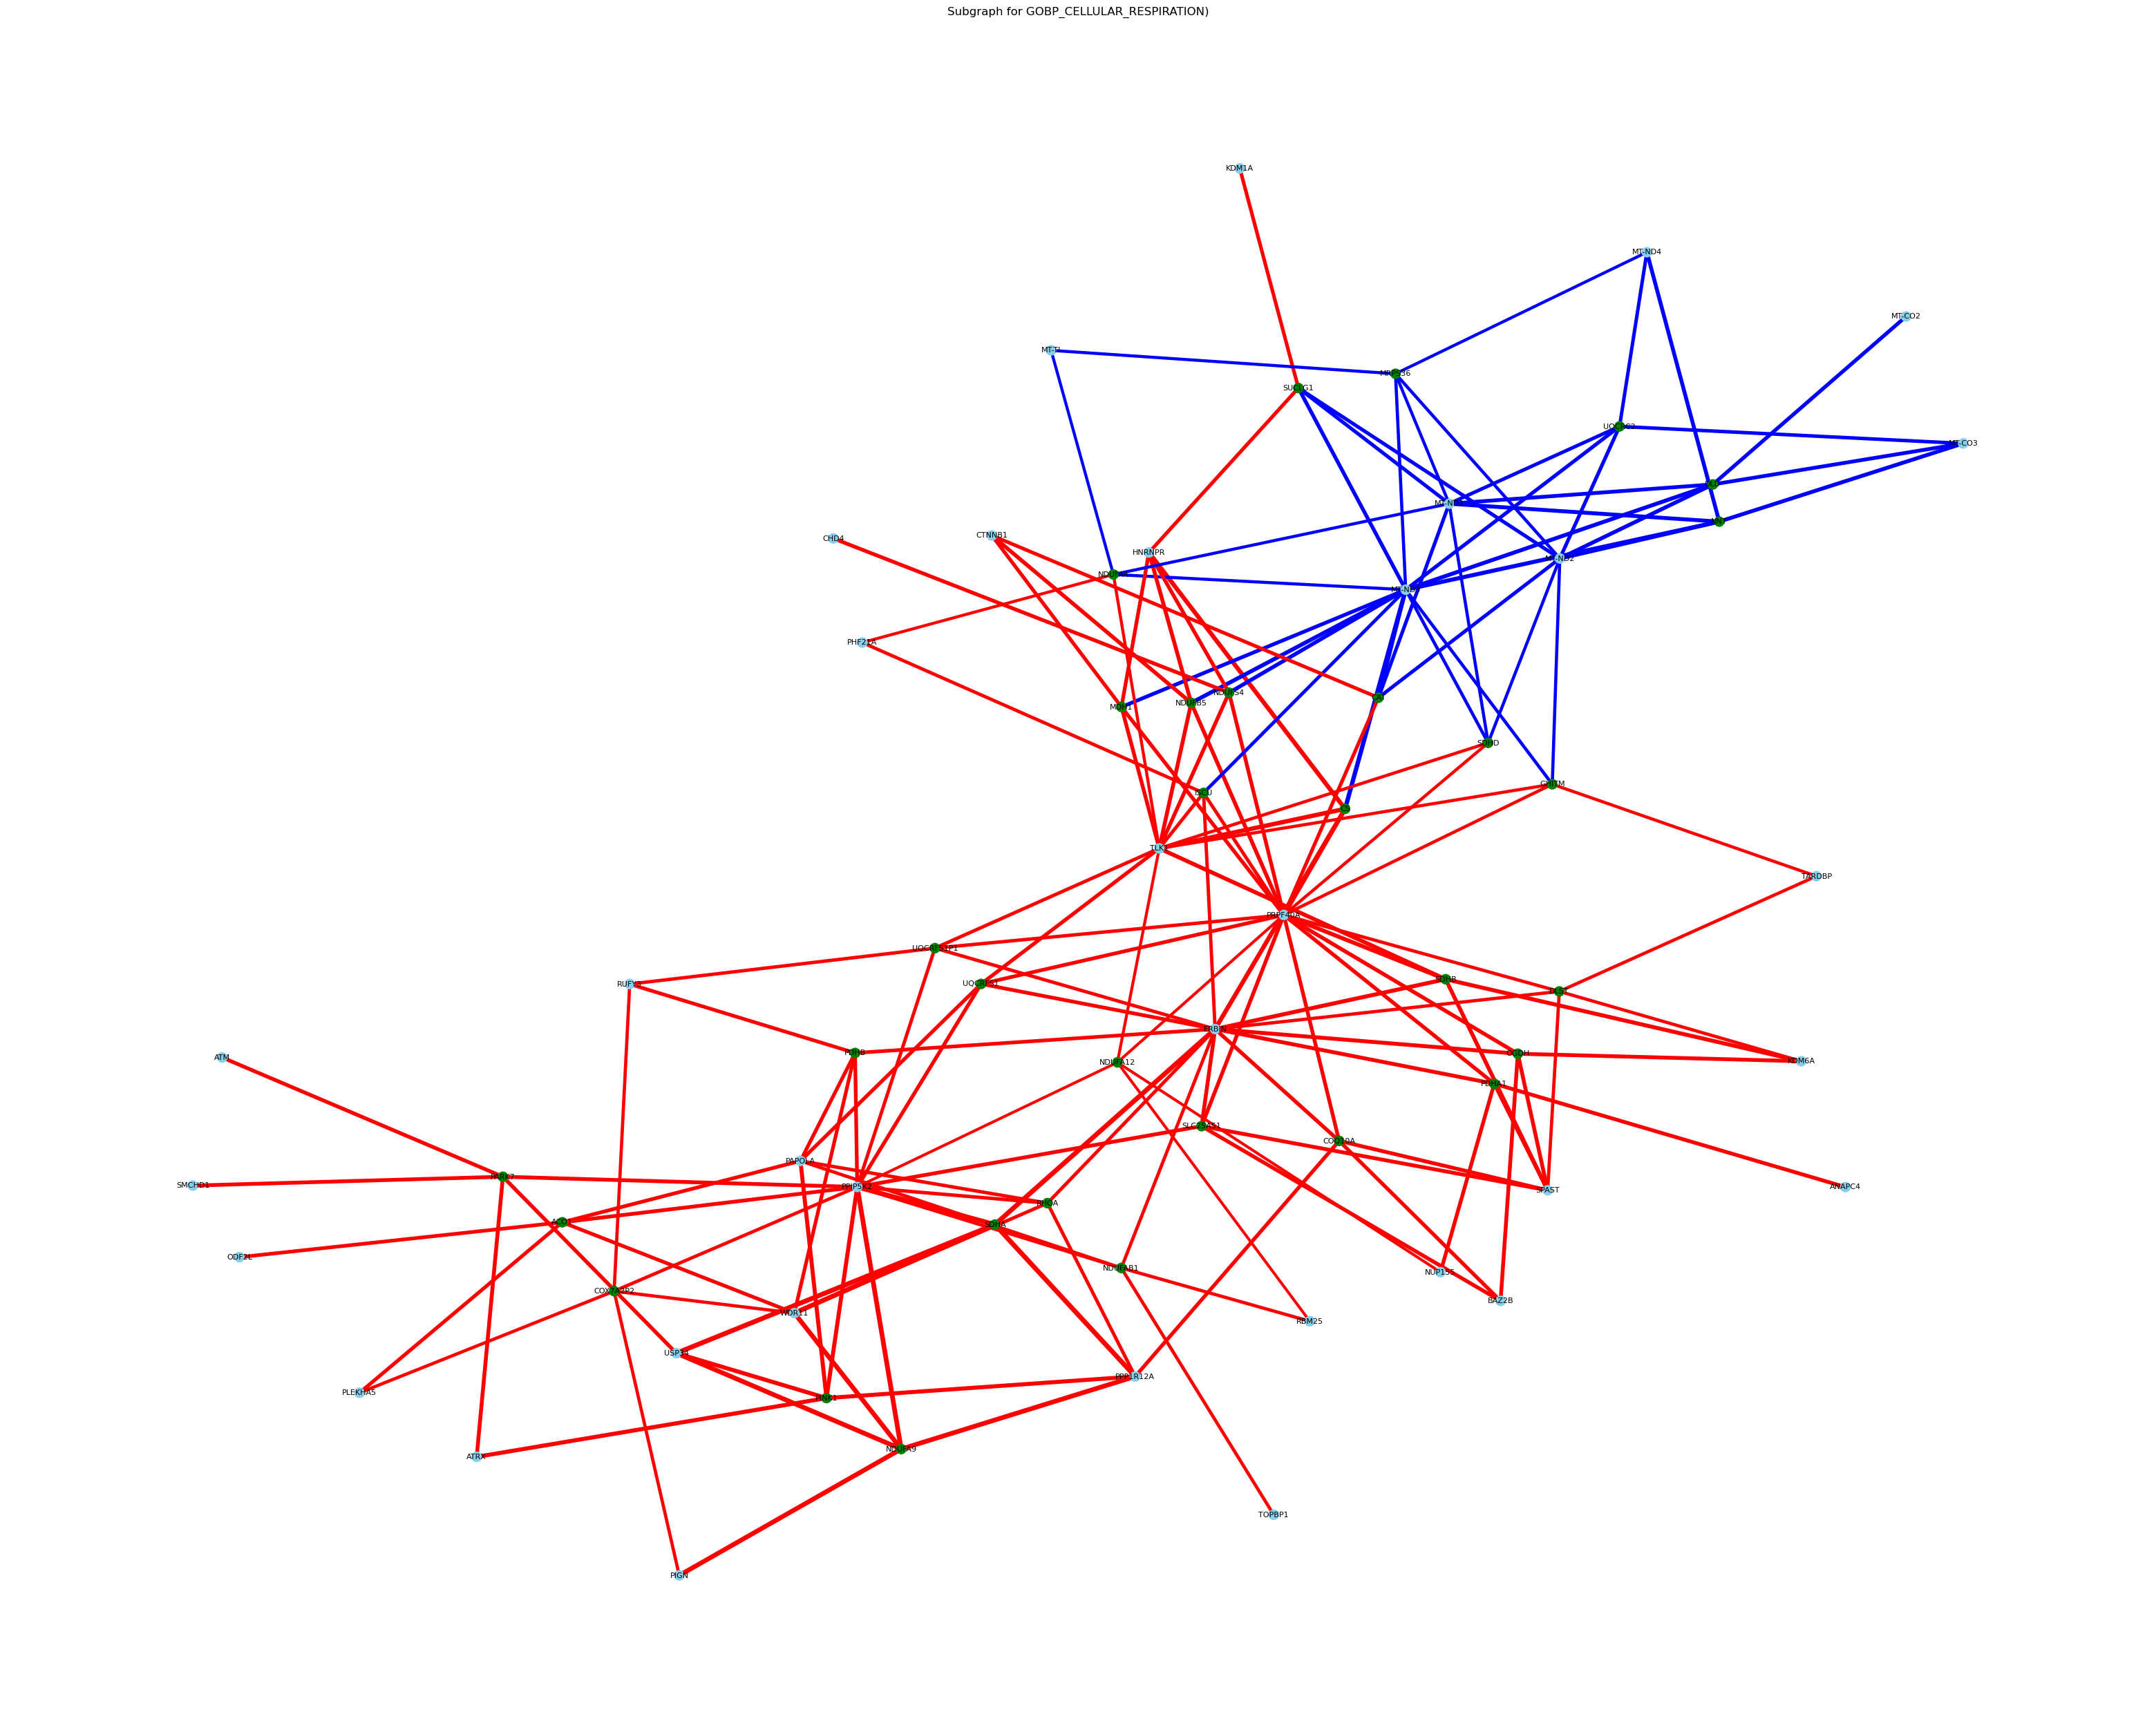

In [12]:
# plot the leading genes of the JAK/STAT pathway


from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

gsea_res_pd = pd.read_csv("../results/results_gsea/"+ora_exp_parent_folder_name+"/BRCA_PANDA_nVSluma_n2v2r_borda_ORA_GOBP_top2_.tsv", sep='\t')
gsea_res_path_leading_genes = gsea_res_pd.loc[gsea_res_pd['pathway'].isin(['GOBP_CELLULAR_RESPIRATION']),'genes']

nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res_path_leading_genes]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))


gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}


dif_net = dataloader.graphs[1] - dataloader.graphs[0]
dif_net_pd = pd.DataFrame(dif_net)
dif_net_pd.index = [ens2symbol[x] for x in dataloader.get_nodes()]
dif_net_pd.columns = [ens2symbol[x] for x in dataloader.get_nodes()]
subgraph_pd = dif_net_pd.loc[nodes_to_plot_mapped, :]


# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]


# Sort the DataFrame by the absolute values, then keep the top 100
edge_list_top_neighbors = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(5)
G = nx.from_pandas_edgelist(edge_list_top_neighbors, source='Source', target='Target', edge_attr=True)


fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed

min_weight = edge_list['Weight'].abs().min()
max_weight = edge_list['Weight'].abs().max()

edge_weights = [5.0*(np.abs(G[u][v]['Weight']) - min_weight)/(max_weight-min_weight) for u, v in G.edges]
edge_colors = ['blue' if G[u][v]['Weight'] < 0 else 'red' for u, v in G.edges]

node_colors = ['green' if node in nodes_to_plot_mapped else 'skyblue'  for node in G.nodes]


nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph for GOBP_CELLULAR_RESPIRATION)")
plt.show()

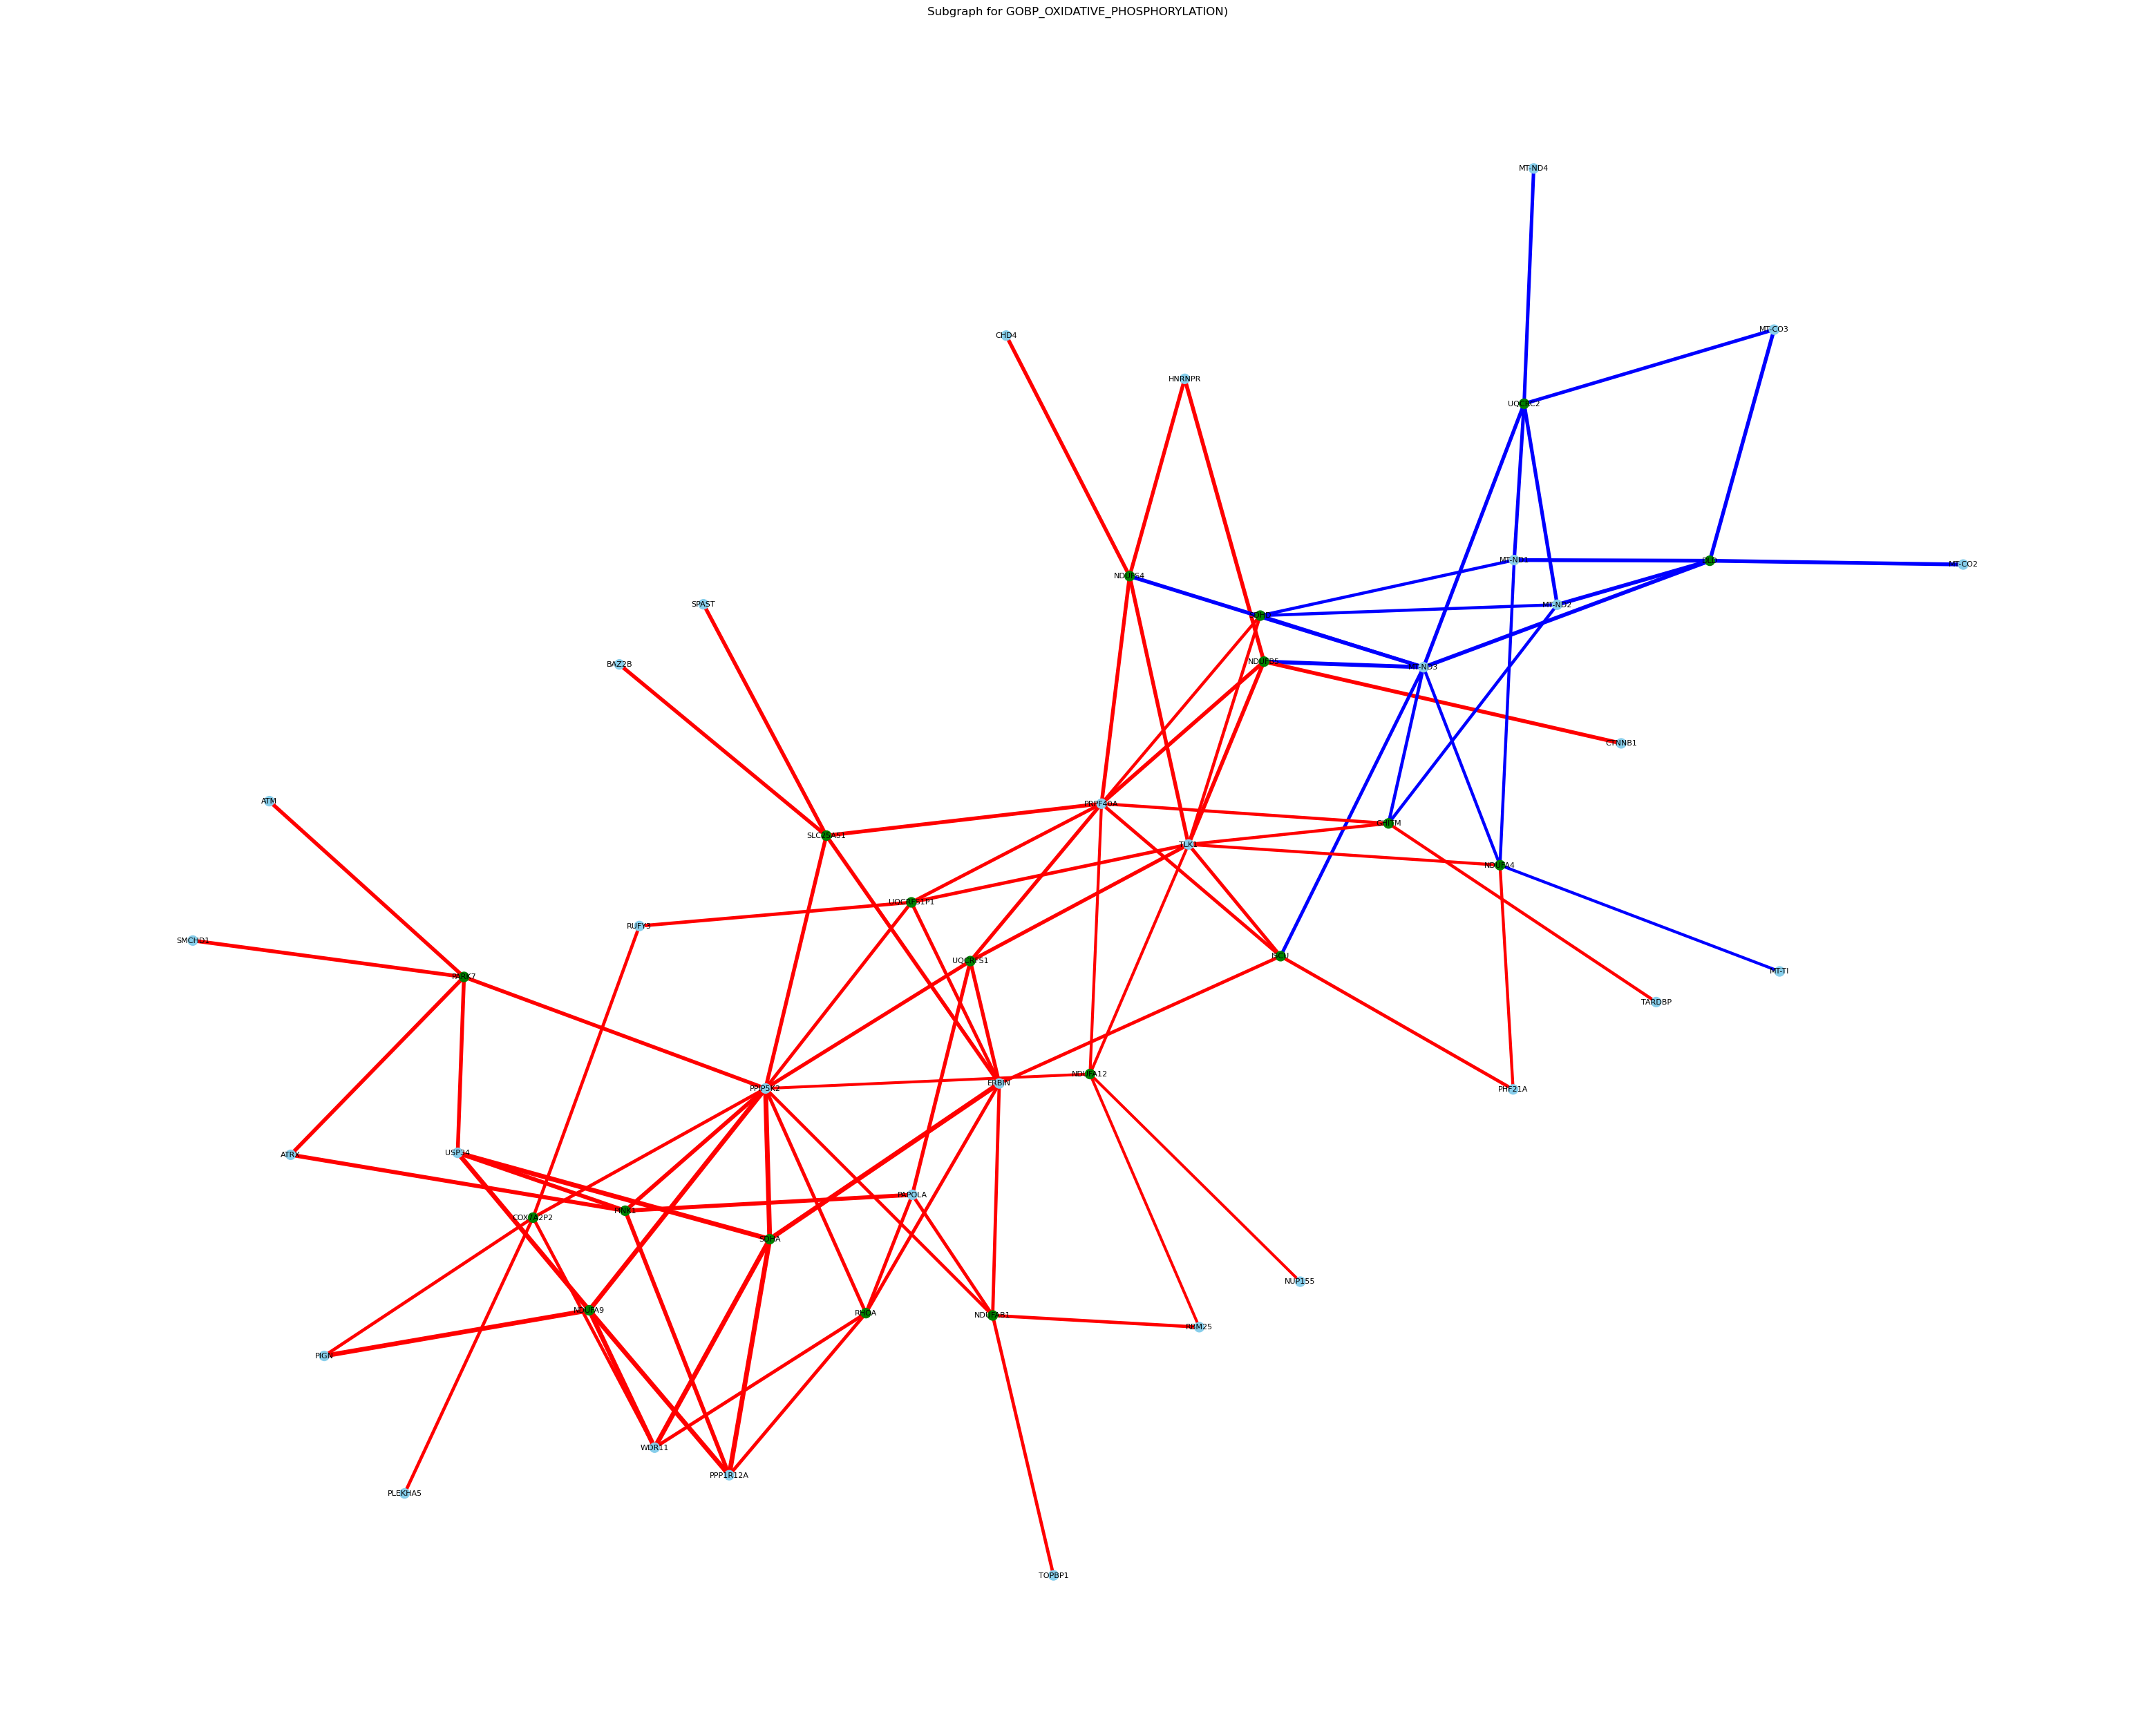

In [14]:
# plot the leading genes of the JAK/STAT pathway


from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

gsea_res_pd = pd.read_csv("../results/results_gsea/"+ora_exp_parent_folder_name+"/BRCA_PANDA_nVSluma_n2v2r_borda_ORA_GOBP_top2_.tsv", sep='\t')
gsea_res_path_leading_genes = gsea_res_pd.loc[gsea_res_pd['pathway'].isin(['GOBP_OXIDATIVE_PHOSPHORYLATION']),'genes']

nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res_path_leading_genes]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))


gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}


dif_net = dataloader.graphs[1] - dataloader.graphs[0]
dif_net_pd = pd.DataFrame(dif_net)
dif_net_pd.index = [ens2symbol[x] for x in dataloader.get_nodes()]
dif_net_pd.columns = [ens2symbol[x] for x in dataloader.get_nodes()]
subgraph_pd = dif_net_pd.loc[nodes_to_plot_mapped, :]


# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]


# Sort the DataFrame by the absolute values, then keep the top 100
edge_list_top_neighbors = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(5)
G = nx.from_pandas_edgelist(edge_list_top_neighbors, source='Source', target='Target', edge_attr=True)


fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed

min_weight = edge_list['Weight'].abs().min()
max_weight = edge_list['Weight'].abs().max()

edge_weights = [5.0*(np.abs(G[u][v]['Weight']) - min_weight)/(max_weight-min_weight) for u, v in G.edges]
edge_colors = ['blue' if G[u][v]['Weight'] < 0 else 'red' for u, v in G.edges]

node_colors = ['green' if node in nodes_to_plot_mapped else 'skyblue'  for node in G.nodes]


nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph for GOBP_OXIDATIVE_PHOSPHORYLATION)")
plt.show()